## Getting started with BombCell

## Install bombcell

Create a conda environment
```bash
conda create -n bombcell python=3.11
conda activate bombcell
```
Clone latest bombcell repository from github
```bash
git clone https://github.com/Julie-Fabre/bombcell.git
```
Install bombcell from local repository
```bash
cd bombcell/pyBombCell
# you could do `pip install .`, but uv is much quicker!
pip install uv
uv pip install . # or uv pip install -e . (-e for editable mode)
```

## Imports

In [1]:
import os, sys
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt

In [2]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

In [3]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

/home/maxime/anaconda3/envs/bombcell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define data paths

By default: path to BombCell's toy dataset

In [4]:
# Replace with your kilosort directory
ks_dir = Path(os.getcwd()) / "toy_data" 

# Leave 'None' if no raw data, ks_dir if raw data is stored with kilosort output,
# or any absolute path to the directory where your data is stored
raw_dir = None # ks_dir

# Eventually replace with the relative directory in which you want to save bombcell's output
ks_dir = Path(ks_dir)
save_path = ks_dir / "bombcell"

# For non-Neuropixels probes, specify conversion factor to uV
gain_to_uV = None # np.nan

In [5]:
# ephys_raw_data and gain_to_uv will be None if no raw_dir given
ephys_raw_data, meta_path, gain_to_uV = bc.manage_if_raw_data(raw_dir, gain_to_uV)

## Get parameters

In [6]:
param = bc.get_default_parameters(ks_dir, raw_file=ephys_raw_data, ephys_meta_dir=meta_path)

print("BombCell parameters:")
pprint(param)

BombCell parameters:
{'compute_distance_metrics': False,
 'compute_drift': False,
 'compute_spatial_decay': True,
 'compute_time_chunks': True,
 'decompress_data': False,
 'delta_time_chunk': 360,
 'detrend_waveform': True,
 'drift_bin_size': 60,
 'duplicate_spikes_window_s': 1e-05,
 'ephys_kilosort_path': PosixPath('/media/maxime/ut_data/Dropbox/Science/bombcell/pyBombCell/Demos/toy_data'),
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extract_raw_waveforms': True,
 'gain_to_uV': None,
 'iso_d_min': 20,
 'keep_only_somatic': True,
 'lratio_max': 0.1,
 'max_RPV': 0.1,
 'max_drift': 100,
 'max_main_peak_to_trough_ratio_non_somatic': 0.8,
 'max_n_peaks': 2,
 'max_n_troughs': 1,
 'max_peak1_to_peak2_ratio_non_somatic': 3,
 'max_perc_spikes_missing': 20,
 'max_scnd_peak_to_trough_ratio_noise': 0.8,
 'max_spatial_decay_slope_exp': -0.1,
 'max_wv_baseline_fraction': 0.3,
 'max_wv_duration': 800,
 'min_SNR': 0,
 'min_amplitude': 20,
 'min_num_spikes_total': 300,
 'min_presence_rati

### Optionally customize parameters

In [7]:
# param["max_RPV"] = 0.1
# param["compute_distance_metrics"] = 0
# param["compute_drift"] = 0
# param["compute_time_chunks"] = 0
# ...

## Run bombcell, get unit types and save results 

Computing bombcell quality metrics: 100%|██████████| 15/15 units


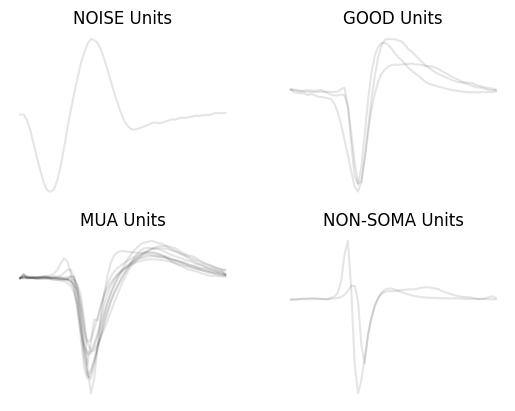

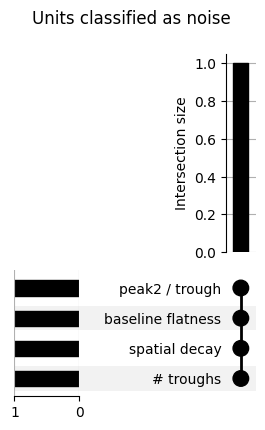

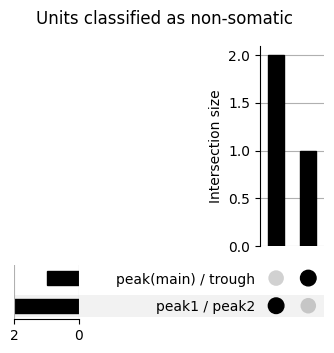

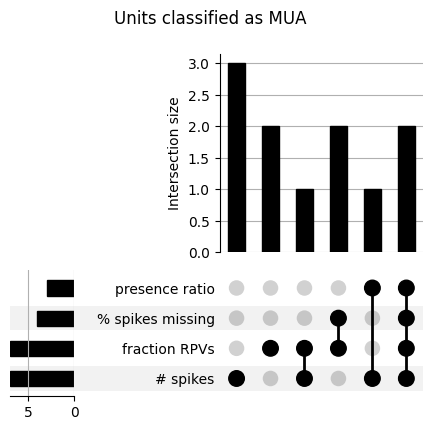

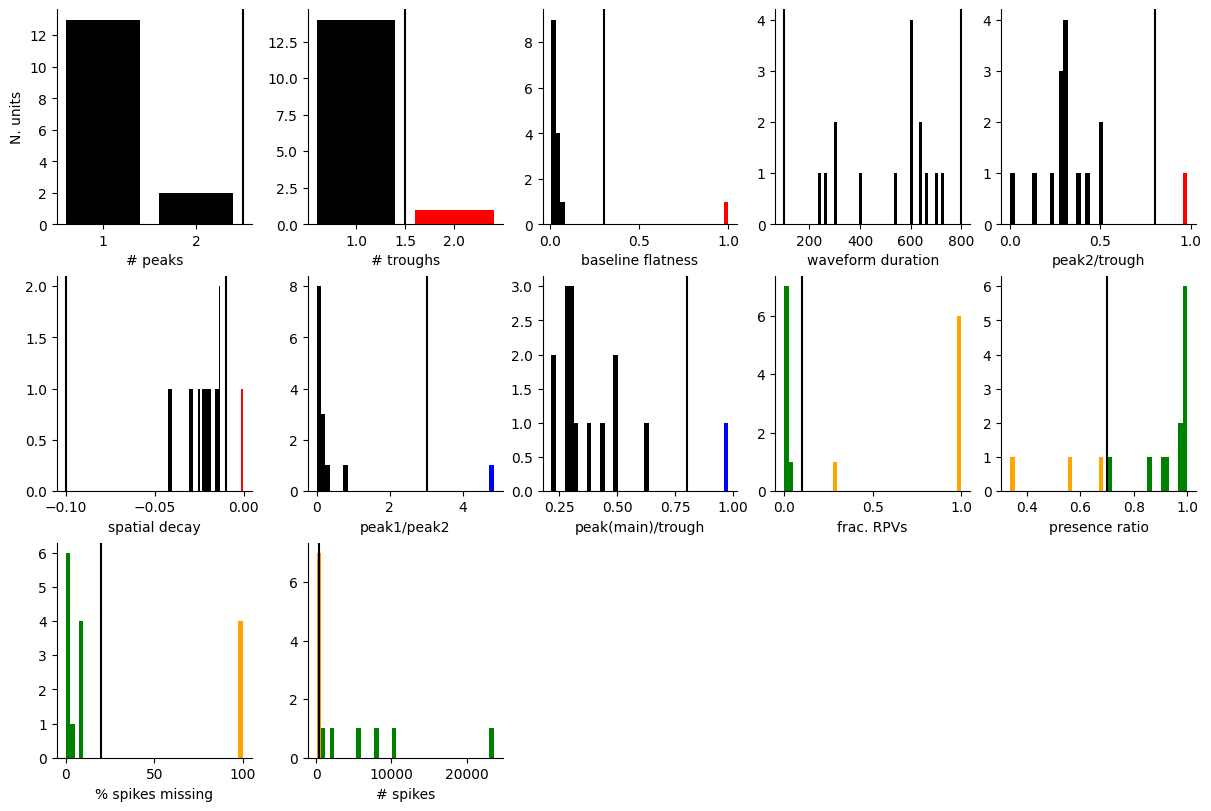

All expected metrics were successfully saved.


In [8]:
param['re_extract_raw'] = False
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, raw_dir, save_path, param
)

Reload quality metrics table

In [9]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

,Bombcell_unit_type,cluster_id,n_spikes,n_peaks,n_troughs,waveform_duration_peak_trough,spatial_decay_slope,waveform_baseline_flatness,scnd_peak_to_trough_ratio,main_peak_to_trough_ratio,peak1_to_peak2_ratio,trough_to_peak2_ratio,peak_before_width,trough_width,percent_missing_gaussian,percent_missing_symmetric,RPV_use_tauR_est,fraction_RPVs,presence_ratio,max_drift_estimate,cumulative_drift_estimate,raw_amplitude,signal_to_noise_ratio,isolation_dist,l_ratio,silhouette_score,use_these_times_start,use_these_times_stop,peak_channels
0,MUA,0,8213.0,1.0,1.0,600.000000,-0.042352,0.021372,0.312463,0.312463,0.283650,11.282845,2.832360,7.318890,9.500735,25.015977,0.0,1.000000,0.862069,24.921079,85.086532,NaN,NaN,NaN,NaN,NaN,0.325367,1800.325367,0
1,NOISE,1,23606.0,1.0,2.0,400.000000,-0.000496,1.000000,0.980433,0.980433,0.001438,709.481628,NaN,8.092349,100.000000,31.339984,0.0,1.000000,1.000000,42.515827,368.110171,NaN,NaN,NaN,NaN,NaN,0.325367,4320.325367,0
2,MUA,2,5881.0,1.0,1.0,733.333333,-0.025323,0.048061,0.431882,0.431882,0.111282,20.806959,0.948645,8.875602,100.000000,23.712544,0.0,1.000000,0.971831,60.730568,393.426453,NaN,NaN,NaN,NaN,NaN,0.325367,4320.325367,2
3,MUA,3,41.0,1.0,1.0,300.000000,-0.040807,0.014625,0.234792,0.234792,0.021125,201.614166,NaN,4.099461,7.888511,0.000000,0.0,0.000000,1.000000,25.002513,38.792876,NaN,NaN,NaN,NaN,NaN,2160.325367,2520.325367,2
4,MUA,4,212.0,2.0,1.0,600.000000,-0.013389,0.057277,0.304664,0.304664,0.844419,3.887054,3.345621,8.822806,2.262779,13.114754,0.0,0.000000,1.000000,7.382259,12.636062,NaN,NaN,NaN,NaN,NaN,360.325367,720.325367,4
5,MUA,5,77.0,1.0,1.0,666.666667,-0.028866,0.044926,0.297345,0.297345,0.151091,22.258665,NaN,6.191829,7.975534,33.620690,0.0,0.000000,1.000000,30.340928,64.222613,NaN,NaN,NaN,NaN,NaN,0.325367,360.325367,6
6,GOOD,6,10606.0,1.0,1.0,266.666667,-0.020930,0.026933,0.492256,0.492256,0.042574,47.715912,NaN,4.136663,0.000000,4.861859,0.0,0.031299,0.924528,20.715800,65.950976,NaN,NaN,NaN,NaN,NaN,720.325367,3960.325367,6
7,MUA,7,161.0,1.0,1.0,600.000000,-0.014845,0.019374,0.288174,0.288174,0.067231,51.614994,NaN,4.139432,100.000000,33.195021,0.0,1.000000,0.676056,53.153589,652.830819,NaN,NaN,NaN,NaN,NaN,0.325367,4320.325367,5
8,MUA,8,218.0,1.0,1.0,600.000000,-0.015257,0.045225,0.303427,0.303427,0.149049,22.111492,NaN,5.895327,0.089420,9.917355,0.0,1.000000,1.000000,19.359647,129.604371,NaN,NaN,NaN,NaN,NaN,1800.325367,3600.325367,9
9,MUA,9,74.0,1.0,1.0,633.333333,-0.019839,0.029477,0.292315,0.292315,0.100840,33.924671,NaN,5.698128,100.000000,31.481481,0.0,1.000000,0.338028,64.342559,378.518034,NaN,NaN,NaN,NaN,NaN,0.325367,4320.325367,11


In [10]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,NaN result,# peaks,# troughs,duration,baseline flatness,peak2 / trough,spatial decay,# spikes,% spikes missing,presence ratio,fraction RPVs,non somatic,peak(main) / trough,peak1 / peak2
0,MUA,0,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,NOISE,1,False,False,True,False,True,True,True,False,True,False,True,True,True,False
2,MUA,2,False,False,False,False,False,False,False,False,True,False,True,False,False,False
3,MUA,3,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,MUA,4,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5,MUA,5,False,False,False,False,False,False,False,True,False,False,False,False,False,False
6,GOOD,6,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,MUA,7,False,False,False,False,False,False,False,True,True,True,True,False,False,False
8,MUA,8,False,False,False,False,False,False,False,True,False,False,True,False,False,False
9,MUA,9,False,False,False,False,False,False,False,True,True,True,True,False,False,False


Example: get all quality metrics for unit 10

In [11]:
u = 12

units = quality_metrics_table.cluster_id
quality_metrics_table.loc[units == u, :]

,Bombcell_unit_type,cluster_id,n_spikes,n_peaks,n_troughs,waveform_duration_peak_trough,spatial_decay_slope,waveform_baseline_flatness,scnd_peak_to_trough_ratio,main_peak_to_trough_ratio,peak1_to_peak2_ratio,trough_to_peak2_ratio,peak_before_width,trough_width,percent_missing_gaussian,percent_missing_symmetric,RPV_use_tauR_est,fraction_RPVs,presence_ratio,max_drift_estimate,cumulative_drift_estimate,raw_amplitude,signal_to_noise_ratio,isolation_dist,l_ratio,silhouette_score,use_these_times_start,use_these_times_stop,peak_channels
12,GOOD,12,354.0,1.0,1.0,300.0,-0.013697,0.077735,0.49462,0.49462,0.088362,22.880278,NaN,6.52303,9.991433,34.926471,0.0,0.0,1.0,4.249339,6.090451,NaN,NaN,NaN,NaN,NaN,2880.325367,3240.325367,12
